In [1]:
import os
import pandas as pd

filedir = os.getcwd()
# filedir = os.path.dirname(os.path.realpath(__file__))
datadir = f"{filedir}/../data"
test_info = pd.read_csv(f"{datadir}/test_info.csv")
test_results = pd.read_csv(f"{datadir}/test_results.csv")
test_specs = pd.read_json(f"{datadir}/test_specs.json", orient="index")
# print(test_specs)
print(test_specs.keys())

Index(['title', 'stepsToReproduce', 'expectedResult'], dtype='object')


In [2]:
import nltk.downloader

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\W+", " ", text)
    # Stemming, only keep word stem
    # stop_words = set(stopwords.words("english"))
    # stemmer = PorterStemmer()
    # text = " ".join(stemmer.stem(word) for word in text.split() if word not in stop_words)
    return text


def preprocess_list(list_of_texts):
    return [preprocess_text(text) for text in list_of_texts]


test_info["Category"] = test_info["Category"].apply(preprocess_text)
test_info["Test Name"] = test_info["Test Name"].apply(preprocess_text)
test_specs["stepsToReproduce"] = test_specs["stepsToReproduce"].apply(preprocess_list)
test_specs["expectedResult"] = test_specs["expectedResult"].apply(preprocess_list)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fedrive/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print(test_specs.iloc[0])

title                                      1 User with 1 watched page
stepsToReproduce    [log in as a simple user, access a page in the...
expectedResult      [the user receives instant 1 2 seconds notific...
Name: https://test.xwiki.org/xwiki/bin/view/NotificationsPerformances/Events%20appear%20in%20the%20notification%20list/1%20User%20with%201%20watched%20page, dtype: object


In [4]:
from sentence_transformers import SentenceTransformer

# Create a pipeline for the BERT model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")


def ensure_string_format(data):
    if isinstance(data, str):
        return data
    elif isinstance(data, list):
        return [str(item) for item in data]  # Convert each item to string if not already
    else:
        print("WARNING, WRONG DATA")
        print(data)
        return str(data)  # Convert other types to string


def get_bert_embedding(text):
    # Get embeddings using the pipeline
    text = ensure_string_format(text)
    embeddings = model.encode(text)
    return embeddings


# Embeddings for each line
test_info["Category_Embedding"] = test_info["Category"].apply(get_bert_embedding)
test_info["TestName_Embedding"] = test_info["Test Name"].apply(get_bert_embedding)
test_specs["expectedResultsEmbeddings"] = test_specs["expectedResult"].apply(get_bert_embedding)
test_specs["stepsToReproduceEmbeddings"] = test_specs["stepsToReproduce"].apply(get_bert_embedding)

In [5]:
from sklearn.cluster import KMeans
import numpy as np

# Flatten all step embeddings into one list

# print(len(test_specs["stepsToReproduceEmbeddings"][0][0]))
"""
for manualTest in test_specs["stepsToReproduceEmbeddings"]:
    print(len(manualTest))
    for stepEmbedding in manualTest:
        print(stepEmbedding.shape)
    break
"""
all_steps_embeddings = [np.array(stepEmbedding, dtype=np.float32) for manualTest in test_specs["stepsToReproduceEmbeddings"] for stepEmbedding in manualTest]

all_expected_results_embeddings = [np.array(stepEmbedding, dtype=np.float32) for manualTest in test_specs["expectedResultsEmbeddings"] for stepEmbedding in manualTest]

In [6]:
def get_num_clusters(cluster_labels):
    unique_labels = set(cluster_labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)
    return len(unique_labels)


def populate_cluster_vectors(cluster_labels_steps, cluster_labels_results):
    populate_vectors_for(cluster_labels_steps, "stepsToReproduceClusters", "stepsToReproduceVector", "stepsToReproduceEmbeddings")
    populate_vectors_for(cluster_labels_results, "expectedResultsClusters", "expectedResultsVector", "expectedResultsEmbeddings")


def populate_vectors_for(cluster_labels, clusters_column, vector_column, embeddings_column):
    test_specs[clusters_column] = [[] for _ in range(len(test_specs))]
    test_specs[vector_column] = [[0] * get_num_clusters(cluster_labels) for _ in range(len(test_specs))]

    property_counter = 0
    test_counter = 0
    for manualTest in test_specs[embeddings_column]:
        for property in manualTest:
            if not isinstance(test_specs[clusters_column].iloc[test_counter], list):
                test_specs[clusters_column].iloc[test_counter] = []
            test_specs[clusters_column].iloc[test_counter].append(cluster_labels[property_counter])
            if cluster_labels[property_counter] != -1:
                test_specs[vector_column].iloc[test_counter][cluster_labels[property_counter]] += 1
            property_counter += 1
        test_counter += 1


def write_data(chosen_algorithm):
    columns_to_exclude = ["expectedResultsEmbeddings", "stepsToReproduceEmbeddings", "expectedResultsVector", "stepsToReproduceVector"]
    modified_test_specs = test_specs.drop(columns=columns_to_exclude)

    json_data = modified_test_specs.to_json(orient="index")
    with open(f"{datadir}/clustered_test_specs_{chosen_algorithm}.json", "w") as file:
        file.write(json_data)

In [7]:
def calculate_failure_rate():
    test_specs["executions"] = 0
    test_specs["failed_executions"] = 0
    test_specs["failure_rate"] = -1

    not_in_specs_counter = 0
    failed_not_in_specs_counter = 0
    for test in test_results.itertuples():
        if test._1 in test_specs.index:
            test_specs.at[test._1, "executions"] += 1
            if test.Verdict == "Failed":
                test_specs.at[test._1, "failed_executions"] += 1
        else:
            print(test._1, "not in test_specs")
            not_in_specs_counter += 1
            not_in_specs_set.add(test._1)
            if test.Verdict == "Failed":
                failed_not_in_specs_counter += 1

    print(
        f"Found {not_in_specs_counter} test executions where the tests could not be found in the test specs file, {failed_not_in_specs_counter} of which failed. ({failed_not_in_specs_counter/not_in_specs_counter*100}%)"
    )
    test_specs["failure_rate"] = np.where(test_specs["executions"] == 0, -1, test_specs["failed_executions"] / test_specs["executions"])


not_in_specs_set = set()
calculate_failure_rate()
print(not_in_specs_set)

https://test.xwiki.org/xwiki/bin/view/Page%20Likes%20Tests/View%20liked%20pages%20for%20an%20user not in test_specs
https://test.xwiki.org/xwiki/bin/view/Page%20Likes%20Tests/View%20liked%20pages%20for%20an%20user not in test_specs
https://test.xwiki.org/xwiki/bin/view/Page%20Likes%20Tests/View%20liked%20pages%20for%20an%20user not in test_specs
https://test.xwiki.org/xwiki/bin/view/Page%20Likes%20Tests/View%20liked%20pages%20for%20an%20user not in test_specs
https://test.xwiki.org/xwiki/bin/view/Page%20Likes%20Tests/View%20liked%20pages%20for%20an%20user not in test_specs
https://test.xwiki.org/xwiki/bin/view/Page%20Likes%20Tests/View%20liked%20pages%20for%20an%20user not in test_specs
https://test.xwiki.org/xwiki/bin/view/Page%20Likes%20Tests/View%20liked%20pages%20for%20an%20user not in test_specs
https://test.xwiki.org/xwiki/bin/view/Page%20Likes%20Tests/View%20Page%20Likes not in test_specs
https://test.xwiki.org/xwiki/bin/view/Page%20Likes%20Tests/View%20Page%20Likes not in test_

# KMeans

In [8]:
num_clusters = 50
kmeans_steps = KMeans(n_clusters=num_clusters, n_init="auto", random_state=0).fit(all_steps_embeddings)

# TODO: ExpectedResults Passende Clusterzahl rausfinden
kmeans_results = KMeans(n_clusters=num_clusters, n_init="auto", random_state=0).fit(all_expected_results_embeddings)

cluster_labels_steps_kmeans = kmeans_steps.predict(all_steps_embeddings)
cluster_labels_results_kmeans = kmeans_results.predict(all_expected_results_embeddings)

populate_cluster_vectors(cluster_labels_steps_kmeans, cluster_labels_results_kmeans)

print(f"Found {get_num_clusters(cluster_labels_steps_kmeans)} kinds of steps and {get_num_clusters(cluster_labels_results_kmeans)} kinds of expected results.")
write_data("KMeans")

Found 50 kinds of steps and 50 kinds of expected results.


# OPTICS

In [9]:
from sklearn.cluster import OPTICS


optics_model = OPTICS()
optics_model.fit(all_steps_embeddings)
cluster_labels_steps_optics = optics_model.labels_

optics_model = OPTICS()
optics_model.fit(all_expected_results_embeddings)
cluster_labels_results_optics = optics_model.labels_

populate_cluster_vectors(
    cluster_labels_steps_optics,
    cluster_labels_results_optics,
)

print(f"Found {get_num_clusters(cluster_labels_steps_optics)} kinds of steps and {get_num_clusters(cluster_labels_results_optics)} kinds of expected results.")
write_data("OPTICS")

/home/fedrive/Studium/Semester_5/Seminar/NLP-Test-Prioritization/python_src/.venv/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Found 547 kinds of steps and 47 kinds of expected results.


# DBSCAN

In [10]:
from sklearn.cluster import DBSCAN

DBSCAN_model = DBSCAN()
DBSCAN_model.fit(all_steps_embeddings)
cluster_labels_steps_dbscan = DBSCAN_model.labels_

DBSCAN_model = DBSCAN()
DBSCAN_model.fit(all_expected_results_embeddings)
cluster_labels_results_dbscan = DBSCAN_model.labels_

populate_cluster_vectors(cluster_labels_steps_dbscan, cluster_labels_results_dbscan)

print(f"Found {get_num_clusters(cluster_labels_steps_dbscan)} kinds of steps and {get_num_clusters(cluster_labels_results_dbscan)} kinds of expected results.")
write_data("DBSCAN")

Found 280 kinds of steps and 23 kinds of expected results.


In [11]:

# print(test_specs.loc[test[1]])

In [12]:
# über cluster iteraten (erstmal random)
# innerhalb cluster dann ranken (erstmal random)
# clustering Parameter rumspielen
# Literatur, Strategie Evaluation anschauen (z.B. APFD)

In [ ]:
kmeans_tests_steps = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(test_specs["stepsToReproduceVector"].tolist())
kmeans_tests_results = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(test_specs["expectedResultsVector"].tolist())

cluster_labels_test_steps_kmeans = kmeans_tests_steps.predict(test_specs["stepsToReproduceVector"].tolist())
cluster_labels_test_results_kmeans = kmeans_tests_results.predict(test_specs["expectedResultsVector"].tolist())

test_specs["stepsToReproduceTestCluster"] = [0 for _ in range(len(test_specs))]

test_counter = 0
for manualTest in test_specs["stepsToReproduceEmbeddings"]:
    test_specs["stepsToReproduceTestCluster"].iloc[test_counter] = cluster_labels_test_steps_kmeans[test_counter]
    test_counter += 1

test_specs["expectedResultsTestCluster"] = [0 for _ in range(len(test_specs))]

test_counter = 0
for manualTest in test_specs["expectedResultsEmbeddings"]:
    test_specs["expectedResultsTestCluster"].iloc[test_counter] = cluster_labels_test_results_kmeans[test_counter]
    test_counter += 1

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
reduced_embeddings = tsne.fit_transform(np.array(all_steps_embeddings))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=3)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Example list of arrays
test_sequences = test_specs["stepsToReproduceClusters"]

# Feature engineering: for example, use the frequency of each cluster ID
max_cluster_id = max(max(sequence) for sequence in test_sequences)
features = np.zeros((len(test_sequences), max_cluster_id + 1))

for i, sequence in enumerate(test_sequences):
    for cluster_id in sequence:
        features[i, cluster_id] += 1

# Now apply a clustering algorithm
kmeans = KMeans(n_clusters=5)  # Number of clusters
kmeans.fit(features)

# Get cluster assignments
cluster_assignments = kmeans.labels_

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
reduced_embeddings = tsne.fit_transform(np.array(all_steps_embeddings))
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
reduced_embeddings = tsne.fit_transform(np.array(all_expectedResults_embeddings))


# TODO: First dimension reduction, then clustering with:
# from sklearn.cluster._optics
# DBSCAN

# Relative zahl an failures, pro test in test_specs aufnehmen

In [ ]:
import matplotlib.pyplot as plt


# Compact plotting
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=3)
plt.title("t-SNE Visualization of Sentence Embeddings")
plt.show()


# Compact plotting
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=3)
plt.title("t-SNE Visualization of Sentence Embeddings")
plt.show()

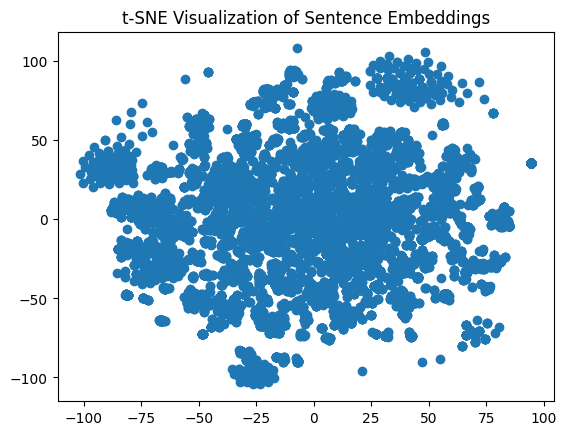


In [ ]:
# Assuming test_specs['stepsToReproduce'] contains the embeddings
first_test_embeddings = [embedding for step in test_specs["stepsToReproduce"].iloc[0] for embedding in step]
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Flatten the embeddings for t-SNE
import numpy as np

# Convert list of embeddings to a 2D NumPy array
flattened_embeddings_array = np.array(flattened_embeddings)

# Then apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(flattened_embeddings_array)

cluster_labels = [label[0] for cluster in test_specs["Step_Clusters"].iloc[0] for label in cluster]

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=cluster_labels,
    cmap="viridis",
)
plt.title("t-SNE visualization of Step Embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.colorbar(scatter)
plt.show()

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming test_specs['stepsToReproduce'] contains the embeddings
first_test_embeddings = [embedding for step in test_specs["stepsToReproduce"].iloc[0] for embedding in step]

# Flatten the embeddings and convert to a 2D NumPy array
flattened_embeddings = [embedding.flatten() for embedding in first_test_embeddings]
flattened_embeddings_array = np.array(flattened_embeddings)

# Apply t-SNE
# Assuming flattened_embeddings_array contains your embeddings
# Check the number of embeddings
num_samples = len(flattened_embeddings_array)
print("Number of samples:", num_samples)

# Set perplexity to a suitable value based on num_samples
perplexity_value = min(30, max(5, num_samples // 2))  # Adjust as needed

# Apply t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
reduced_embeddings = tsne.fit_transform(flattened_embeddings_array)

# Extract cluster labels for the first test
cluster_labels = [label[0] for cluster in test_specs["Step_Clusters"].iloc[0] for label in cluster]

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=cluster_labels,
    cmap="viridis",
)
plt.title("t-SNE visualization of Step Embeddings")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.colorbar(scatter)
plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Konvertiere die Listen von Arrays in eine Matrix
category_embeddings = np.vstack(test_info["Category_Embedding"].apply(lambda x: x.squeeze()).tolist())
testname_embeddings = np.vstack(test_info["TestName_Embedding"].apply(lambda x: x.squeeze()).tolist())

# Bestimme die Anzahl der Komponenten für PCA
# Da wir die Anzahl der Features (768) haben, können wir n_components kleiner als diese Zahl wählen
n_components = min(category_embeddings.shape[0], 50)  # oder jede andere Zahl, die du für angemessen hältst

# Wende PCA an
pca = PCA(n_components=n_components)
category_reduced = pca.fit_transform(category_embeddings)
testname_reduced = pca.fit_transform(testname_embeddings)

# Füge die reduzierten Daten zum DataFrame hinzu
test_info["Category_Reduced"] = list(category_reduced)
test_info["TestName_Reduced"] = list(testname_reduced)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the number of clusters using the elbow method
wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=0)
    kmeans.fit(category_reduced)
    wcss.append(kmeans.inertia_)

In [ ]:
# Choose the number of clusters as where the elbow occurs
n_clusters = 8

# Apply K-Means clustering
kmeans = KMeans(
    n_clusters=n_clusters,
    init="k-means++",
    max_iter=300,
    n_init=10,
    random_state=0,
)
test_info["Category_Cluster"] = kmeans.fit_predict(category_reduced)
test_info["TestName_Cluster"] = kmeans.fit_predict(testname_reduced)

# Check the silhouette score
from sklearn.metrics import silhouette_score

silhouette_cat = silhouette_score(category_reduced, test_info["Category_Cluster"])
silhouette_test = silhouette_score(testname_reduced, test_info["TestName_Cluster"])
print(f"Silhouette Score for Category: {silhouette_cat}")
print(f"Silhouette Score for Test Name: {silhouette_test}")

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce to two dimensions
tsne = TSNE(n_components=2, random_state=0)
category_2d = tsne.fit_transform(category_reduced)
testname_2d = tsne.fit_transform(testname_reduced)

# Plotting the clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(category_2d[:, 0], category_2d[:, 1], c=test_info["Category_Cluster"])
plt.title("Category Clusters")

plt.subplot(1, 2, 2)
plt.scatter(testname_2d[:, 0], testname_2d[:, 1], c=test_info["TestName_Cluster"])
plt.title("Test Name Clusters")

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Reduce dimensions to 3 components for 3D visualization
tsne_3d = TSNE(n_components=3, random_state=0)
category_3d = tsne_3d.fit_transform(category_reduced)
testname_3d = tsne_3d.fit_transform(testname_reduced)

# Plotting the clusters in 3D
fig = plt.figure(figsize=(16, 8))

# Category clusters
ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(
    category_3d[:, 0],
    category_3d[:, 1],
    category_3d[:, 2],
    c=test_info["Category_Cluster"],
)
ax1.set_title("Category Clusters in 3D")

# Test Name clusters
ax2 = fig.add_subplot(122, projection="3d")
ax2.scatter(
    testname_3d[:, 0],
    testname_3d[:, 1],
    testname_3d[:, 2],
    c=test_info["TestName_Cluster"],
)
ax2.set_title("Test Name Clusters in 3D")

plt.show()

In [ ]:
# Elbow method to find out number of clusters
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

k_values = range(2, 60)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(all_steps_embeddings)
    inertia_values.append(kmeans.inertia_)
    print(f"{k}/{k_values.stop-1}", end="\r")

# Plotting
plt.plot(k_values, inertia_values, "bo-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method For Optimal k")
plt.show()

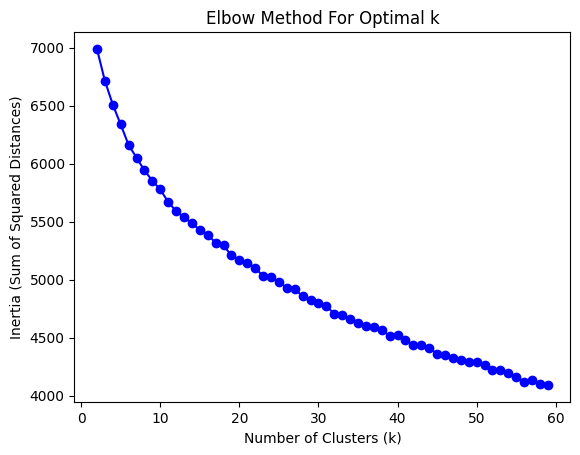


In [ ]:
from transformers import AutoTokenizer, AutoModel, BertModel
import torch

# BERT Model und Tokenizer laden
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# move model to cuda if cuda is available
model = model.to("cuda") if torch.cuda.is_available() else model


def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # move inputs to cuda if cuda is available
    inputs = {k: v.to("cuda") for k, v in inputs.items()} if torch.cuda.is_available() else inputs

    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()


def get_bert_embedding_for_list(list_of_text):
    return [get_bert_embedding(text) for text in list_of_text]


# Embeddings für jede Zeile berechnen
test_info["Category_Embedding"] = test_info["Category"].apply(get_bert_embedding)
test_info["TestName_Embedding"] = test_info["Test Name"].apply(get_bert_embedding)
test_specs["expectedResult"] = test_specs["expectedResult"].apply(get_bert_embedding_for_list)
test_specs["stepsToReproduce"] = test_specs["stepsToReproduce"].apply(get_bert_embedding_for_list)